### Import Packages

In [38]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 1
%matplotlib inline


import tensorflow as tf
import os
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas_datareader.data as web
import datetime

### Get WTI crude oil daily prices of last 20 years

In [61]:
start_date = datetime.datetime.now() - datetime.timedelta(days=365*20) # 20 years ago
end_date = datetime.datetime.now()

wti = web.DataReader('DCOILWTICO', 'fred', start_date, end_date)
wti=wti.resample('W').mean()
wti=wti.rename({'DCOILWTICO':'WTI'}, axis=1)

In [62]:
wti.isnull().sum()

WTI    0
dtype: int64

Text(0.5, 1.0, 'WTI Crude Oil Monthly Price - USD/bbl')

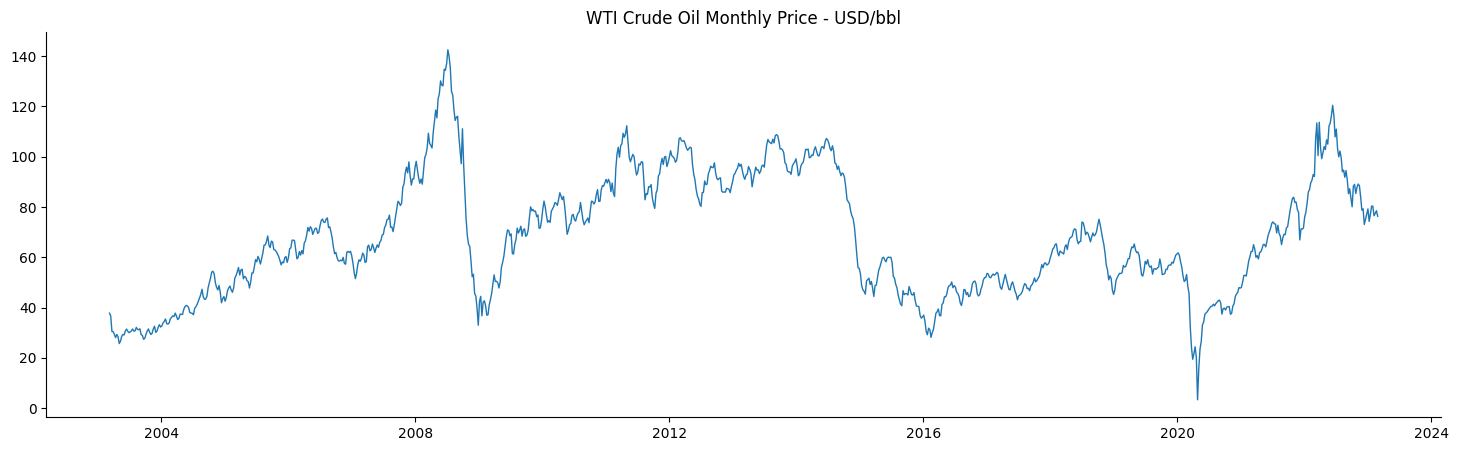

In [64]:
plt.plot(wti)
plt.title('WTI Crude Oil Monthly Price - USD/bbl')

### Check Stationary

1. A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. Whether a TS is stationary is important since
    * Stationary processes are easier to analyze
    * Most forecasting algorithms assume a series is stationary
2. One way to test if a TS is stationary is to plot the rolling mean and rolling standard deviation. If the TS is stationary, then the rolling mean and rolling standard deviation should be constant over time
3. Augmented Dicky-Fuller test, or ADF test is frequently used to determine whether a TS is stationary. It is actually a simple hypothesis testing where
    * Null hypothesis (H0) — Time series is not stationary
    * Alternative hypothesis (H1) — Time series is stationary
4. KPSS is another test for stationarity. It is also a hypothesis testing where
    * Null hypothesis (H0) — Time series is stationary
    * Alternative hypothesis (H1) — Time series is not stationary

#### Rolling Statistics

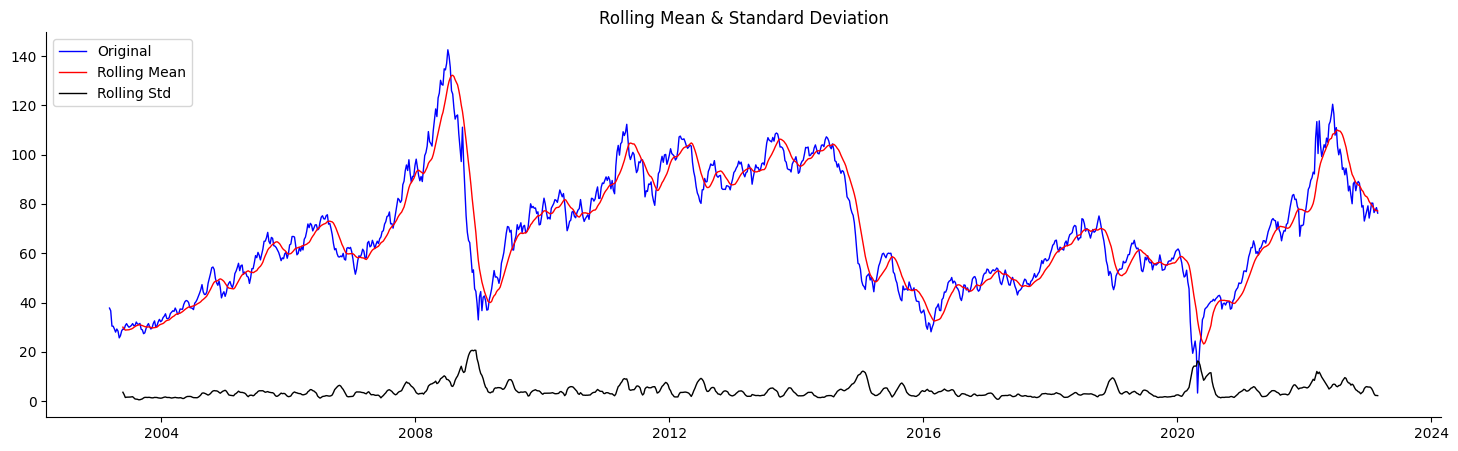

In [96]:
def rolling_statistics(timeseries):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
rolling_statistics(wti)

#### ADF Test

In [67]:
adfinput = adfuller(wti['WTI'])
adftest = pd.Series(adfinput[0:4], index=['Dickey Fuller Statistical Test', 'P-value',
                                          'Used Lags', 'Number of comments used'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Critical Value (%s)"%key] = value.round(4) 

adftest

Dickey Fuller Statistical Test      -3.2030
P-value                              0.0198
Used Lags                           17.0000
Number of comments used           1025.0000
Critical Value (1%)                 -3.4367
Critical Value (5%)                 -2.8644
Critical Value (10%)                -2.5683
dtype: float64

As the P-value is smaller than 0.05, we can reject the null hypothesis and say that the TS is stationary

#### KPSS Test

In [68]:
kpssinput = kpss(wti['WTI'])
kpsstest = pd.Series(kpssinput[0:3], index=['Statistical Test KPSS', 'P-Value', 'Used Lags'])
kpsstest = round(kpsstest,4)
    
for key, value in kpssinput[3].items():
    kpsstest["Critical Value (%s)"%key] = value 

kpsstest

Statistical Test KPSS     0.4831
P-Value                   0.0455
Used Lags                19.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
dtype: float64

As the P-value is also smaller than 0.05, we reject the null hypothesis and say that the TS is not stationary

### Transform TS

As the ADF and KPSS generate different results, we need to transform the TS to make it stationary

#### Differencing

In [69]:
def determine_differencing_level(ts):
    # Run the ADF test
    adf_results = adfuller(ts)
    adf_pvalue = adf_results[1]

    # Run the KPSS test
    kpss_results = kpss(ts)
    kpss_pvalue = kpss_results[1]

    # Check if the series is stationary without differencing
    if adf_pvalue < 0.05 and kpss_pvalue > 0.05:
        return 0

    # Check if the series is non-stationary with differencing
    for d in range(1, len(ts)):
        ts_diff = np.diff(ts, n=d)
        adf_results = adfuller(ts_diff)
        adf_pvalue = adf_results[1]
        kpss_results = kpss(ts_diff)
        kpss_pvalue = kpss_results[1]

        # If both tests indicate stationarity, return the differencing level
        if adf_pvalue < 0.05 and kpss_pvalue > 0.05:
            return d

    # If the series cannot be made stationary with differencing, return None
    return None

In [70]:
determine_differencing_level(wti['WTI'])

1

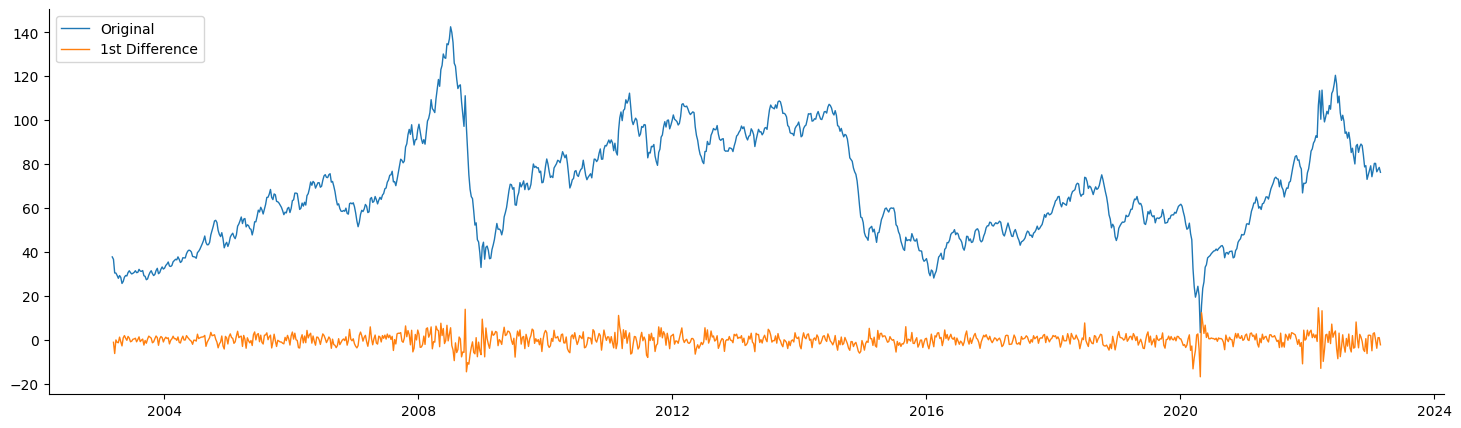

In [90]:
wti_diff=wti.diff(1).dropna()
plt.plot(wti,label='Original')
plt.plot(wti_diff,label='1st Difference')
plt.legend(loc='upper left')

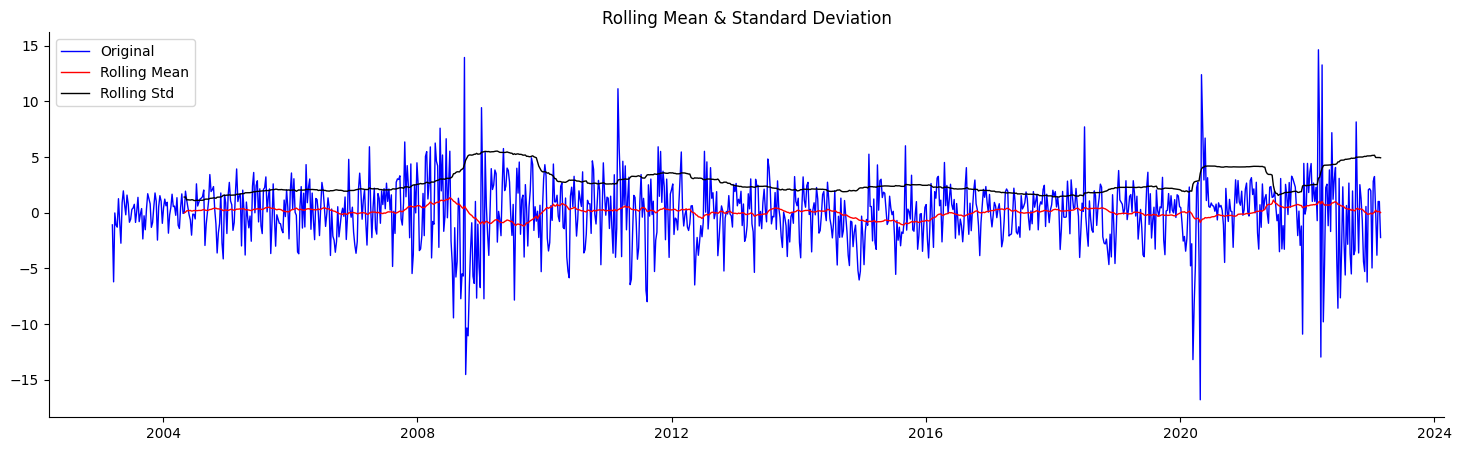

In [95]:
rolling_statistics(wti_diff)

#### Log Transformation

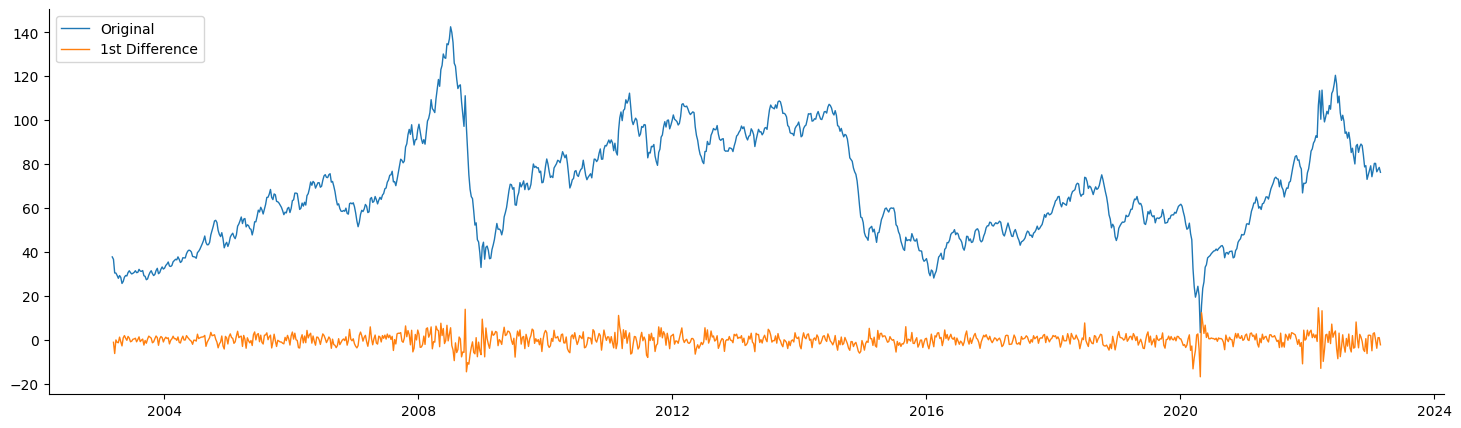

In [97]:
wti_log=np.log(wti).dropna()
plt.plot(wti,label='Original')
plt.plot(wti_diff,label='1st Difference')
plt.legend(loc='upper left')

In [98]:
determine_differencing_level(wti_log['WTI'])

1

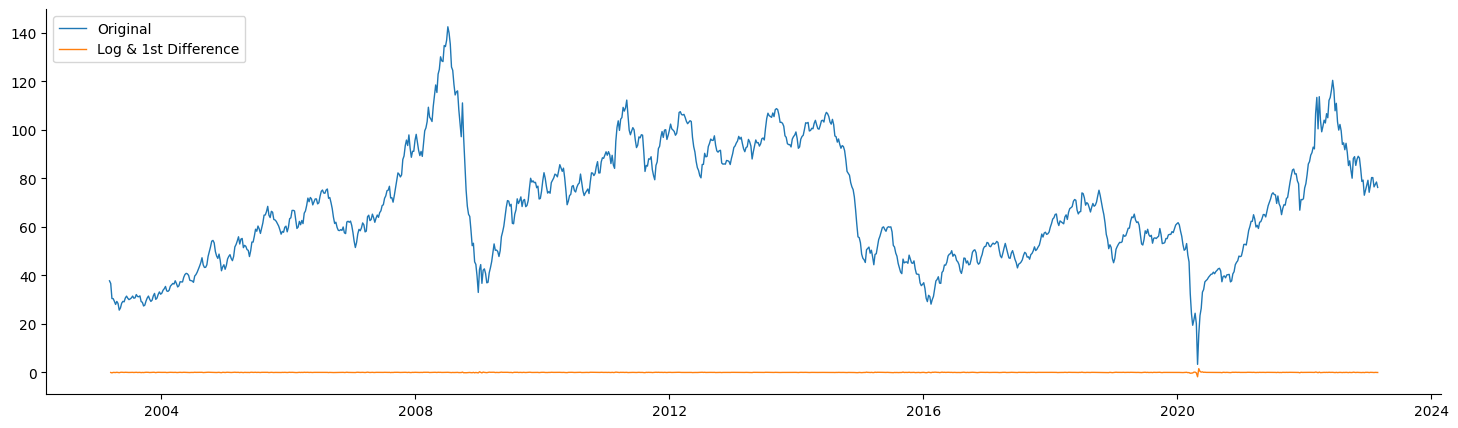

In [100]:
wti_log_diff=wti_log.diff(1).dropna()
plt.plot(wti,label='Original')
plt.plot(wti_log_diff,label='Log & 1st Difference')
plt.legend(loc='upper left')

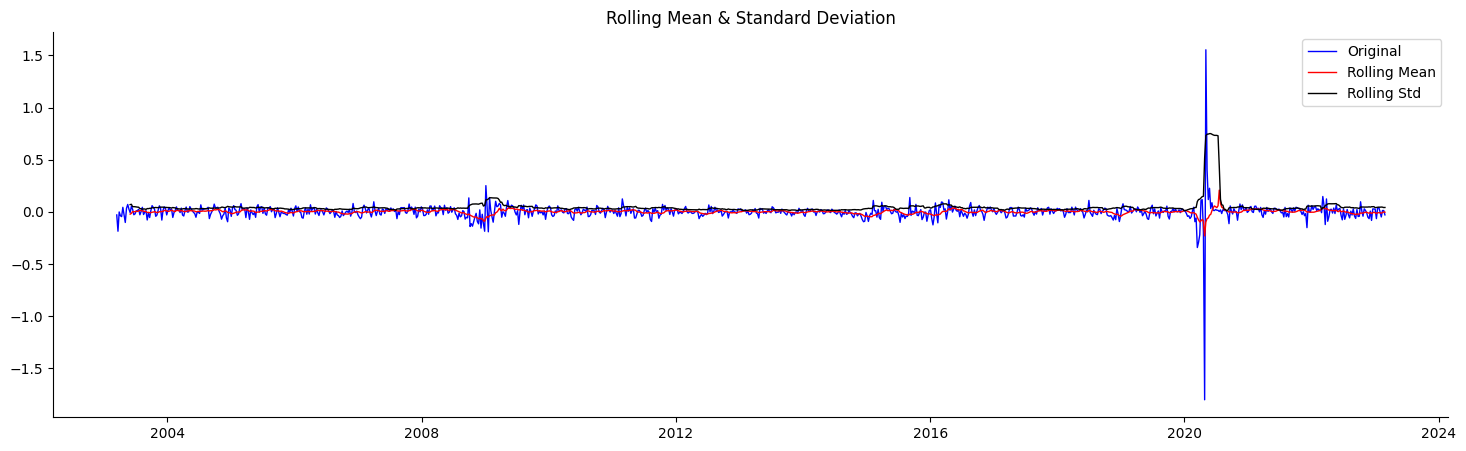

In [101]:
rolling_statistics(wti_log_diff)

#### Subtract Rolling Mean

In [105]:
rolling_mean = wti_log.rolling(window=12).mean()
wti_log_minus_mean = wti_log - rolling_mean
wti_log_minus_mean.dropna(inplace=True)

In [107]:
determine_differencing_level(wti_log_minus_mean)

0

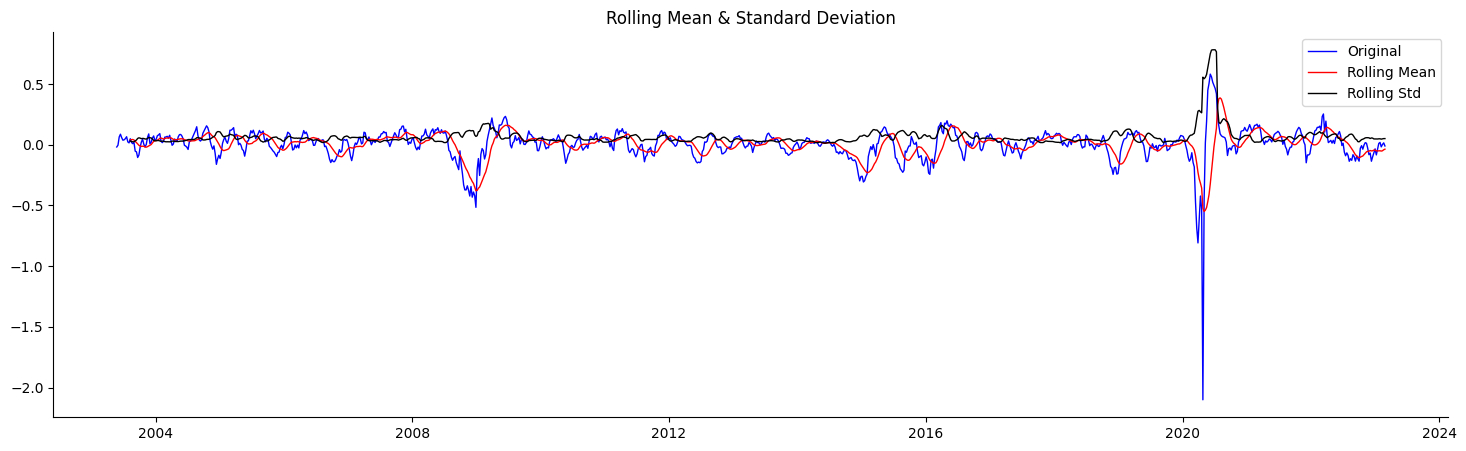

In [106]:
rolling_statistics(wti_log_minus_mean)

#### Exponential Decay

In [108]:
rolling_mean_exp_decay = wti_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
wti_log_exp_decay = wti_log - rolling_mean_exp_decay
wti_log_exp_decay.dropna(inplace=True)

In [109]:
determine_differencing_level(wti_log_exp_decay)

0

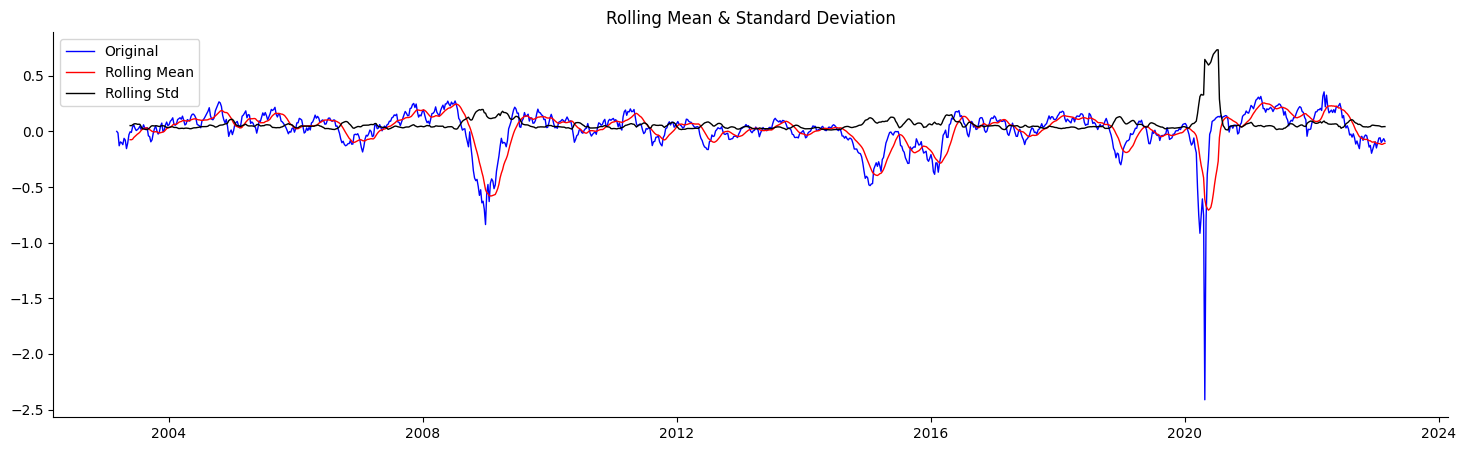

In [110]:
rolling_statistics(wti_log_exp_decay)

### Modeling

#### Train Test Split

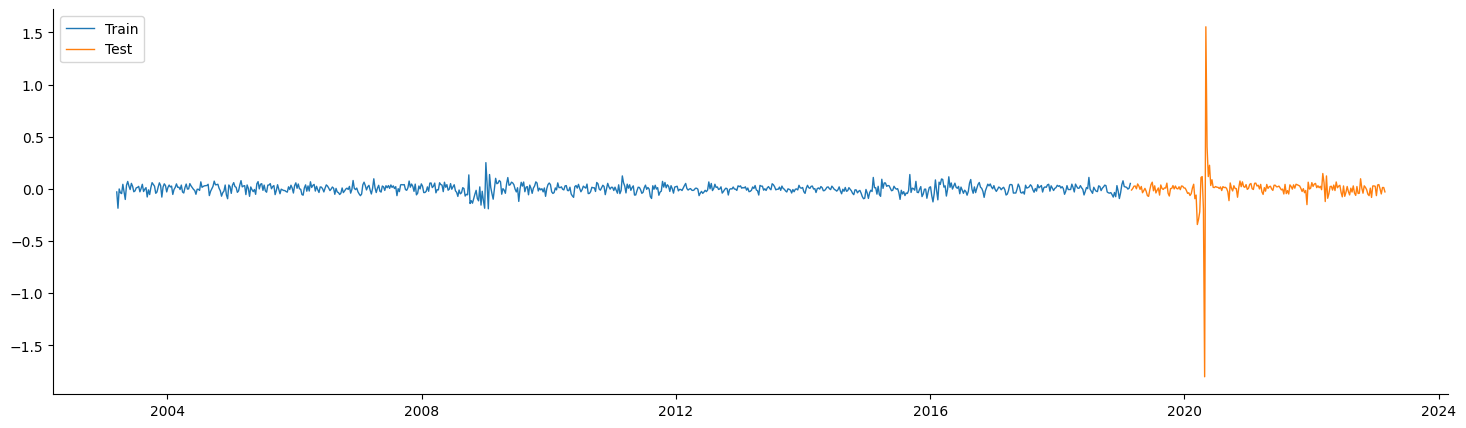

In [102]:
test_size=int(np.ceil(len(wti_log_diff)*0.2))

train=wti_log_diff[:-test_size]
test=wti_log_diff[-test_size:]

plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.legend(loc='upper left')

Log and first difference make the TS more stationary

#### ARIMA

1. Three integers (p, d, q) are typically used to parametrize ARIMA models.
    * p: number of autoregressive terms (AR order)
    * d: number of nonseasonal differences (differencing order)
    * q: number of moving-average terms (MA order)
2. Auto Correlation Function (ACF)
    * ACF is a measure of the correlation between the TS with a lagged version of itself
    * For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and t1 being end points)
    * ACF is useful to identify the MA term
3. Partial Auto Correlation Function (PACF)
    * PACF measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons
    * PACF is useful to identify the AR term